# Denial Prompting RL

- model: GPT-2 (124M parameters)
- data: NeoCoder dataset (subset of 10 problems)
- training: 50 GRPO steps with actual gradient updates
- GPU: Google Colab T4

**Runtime:** 5 min (testing if it works)


In [12]:
# Verify GPU is available
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("GPU not available. Enable it in Runtime settings.")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


## Clone Repository

In [13]:
%cd /content
!rm -rf dprl

!git clone https://github.com/thongthornpatch/dprl.git

%cd dprl
!pwd

/content
Cloning into 'dprl'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 183 (delta 81), reused 61 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (183/183), 108.09 KiB | 7.21 MiB/s, done.
Resolving deltas: 100% (81/81), done.
/content/dprl
/content/dprl


## Install Dependencies

In [14]:
# Install required packages
!pip install -q transformers>=4.35.0 datasets>=2.14.0 RestrictedPython>=6.0 tqdm pyyaml
print("Dependencies installed")

Dependencies installed


## Download NeoCoder Dataset (Subset)

In [15]:
# Download NeoCoder dataset
!python scripts/download_neocoder.py

NeoCoder Dataset Setup

Project root: /content/dprl
Data directory: /content/dprl/data/raw

Cloning NeoCoder repository...
Repository cloned successfully!

Verifying dataset files...
datasets/CodeForce/NeoCoder/NeoCoder.json (3.5 MB)
datasets/CodeForce/NeoCoder/test_cases_annotated.json (1.6 MB)
datasets/CodeForce/NeoCoder/human_solutions.json (1.4 MB)
datasets/CodeForce/NeoCoder/human_solution_techniques.json (0.4 MB)

Running sanity checks...
NeoCoder.json: 199 problems
test_cases_annotated.json: 499 test case entries
Data structure valid


## Verify Setup

In [16]:
# Test all components
!python scripts/test_setup.py

SETUP VERIFICATION TEST

Testing imports...
yaml imported
numpy imported
config_loader imported

Testing configuration loading...
Laptop config loaded
Laptop config validated
NSCC config loaded
NSCC config validated

Testing logging utilities...
Logger created
Metrics logger working

Testing directory structure...
configs
src/data
src/models
src/training
src/rewards
src/evaluation
src/utils
data/raw
data/processed
logs
experiments
scripts

Testing basic code execution safety concepts...
Safe code execution works
Dangerous imports detected (basic check)

TEST SUMMARY
PASS  Imports
PASS  Configuration Loading
PASS  Logging Utilities
PASS  Directory Structure
PASS  Sandbox Basics

Total: 5/5 tests passed

All tests passed. Setup is ready.

Next steps:
  1. Run: python scripts/download_neocoder.py (coming soon)
  2. Implement reward function
  3. Implement GRPO training loop


## Run Pilot Training (50 steps)

This will:
- Load GPT-2 model (~500MB download on first run)
- Generate code using the model
- Compute rewards based on correctness and denial penalties
- Update model weights using GRPO
- Save metrics and checkpoints


In [17]:
# Run actual training with real model
!python scripts/train.py \
    --config configs/config_colab.yaml \
    --output_dir outputs/colab_pilot

DENIAL PROMPTING RL TRAINING
Config: configs/config_colab.yaml
Output directory: outputs/colab_pilot

Loading configuration...
Config loaded
Model: gpt2
Device: cuda
Training steps: 50
Batch size: 2
Group size: 4

Loading NeoCoder dataset...
Loaded 199 problems
Total rounds: 1194
Curriculum enabled: True

Initializing model...
Loading model: gpt2
  Device: cuda
  Dtype: float32
`torch_dtype` is deprecated! Use `dtype` instead!
2026-01-19 08:40:14.470160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768812014.487056   18127 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768812014.491946   18127 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 

## Analyze Results

In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load training metrics
with open('outputs/colab_pilot/metrics.json') as f:
    metrics = json.load(f)

# Extract data
steps = sorted([int(k) for k in metrics.keys()])
rewards = [metrics[str(s)]['mean_reward'] for s in steps]
violations = [metrics[str(s)]['mean_violations'] for s in steps]
success_rates = [metrics[str(s)]['success_rate'] for s in steps]
losses = [metrics[str(s)]['loss'] for s in steps]

print("="*80)
print("TRAINING RESULTS SUMMARY")
print("="*80)
print(f"\nTotal steps: {len(steps)}")
print(f"\nReward Statistics:")
print(f"Initial reward: {rewards[0]:.3f}")
print(f"Final reward: {rewards[-1]:.3f}")
print(f"Change: {rewards[-1] - rewards[0]:+.3f}")
print(f"Max reward: {max(rewards):.3f}")

# Compare first vs second half
mid = len(rewards) // 2
first_half = sum(rewards[:mid]) / mid
second_half = sum(rewards[mid:]) / (len(rewards) - mid)
print(f"\nLearning Progress:")
print(f"First half average: {first_half:.3f}")
print(f"Second half average: {second_half:.3f}")
if second_half > first_half:
    print(f"Improving! (+{second_half - first_half:.3f})")
else:
    print(f"Declining ({second_half - first_half:.3f})")

print(f"\nViolations:")
print(f"Average: {sum(violations)/len(violations):.2f}")
print(f"Initial: {violations[0]:.2f}")
print(f"Final: {violations[-1]:.2f}")

print(f"\nSuccess Rate:")
print(f"Average: {sum(success_rates)/len(success_rates):.1%}")
print(f"Initial: {success_rates[0]:.1%}")
print(f"Final: {success_rates[-1]:.1%}")

print("\n" + "="*80)

TRAINING RESULTS SUMMARY

Total steps: 50

Reward Statistics:
Initial reward: 0.000
Final reward: 0.000
Change: +0.000
Max reward: 0.000

Learning Progress:
First half average: 0.000
Second half average: 0.000
Declining (0.000)

Violations:
Average: 0.00
Initial: 0.00
Final: 0.00

Success Rate:
Average: 0.0%
Initial: 0.0%
Final: 0.0%



## 8 Visualize Training Progress

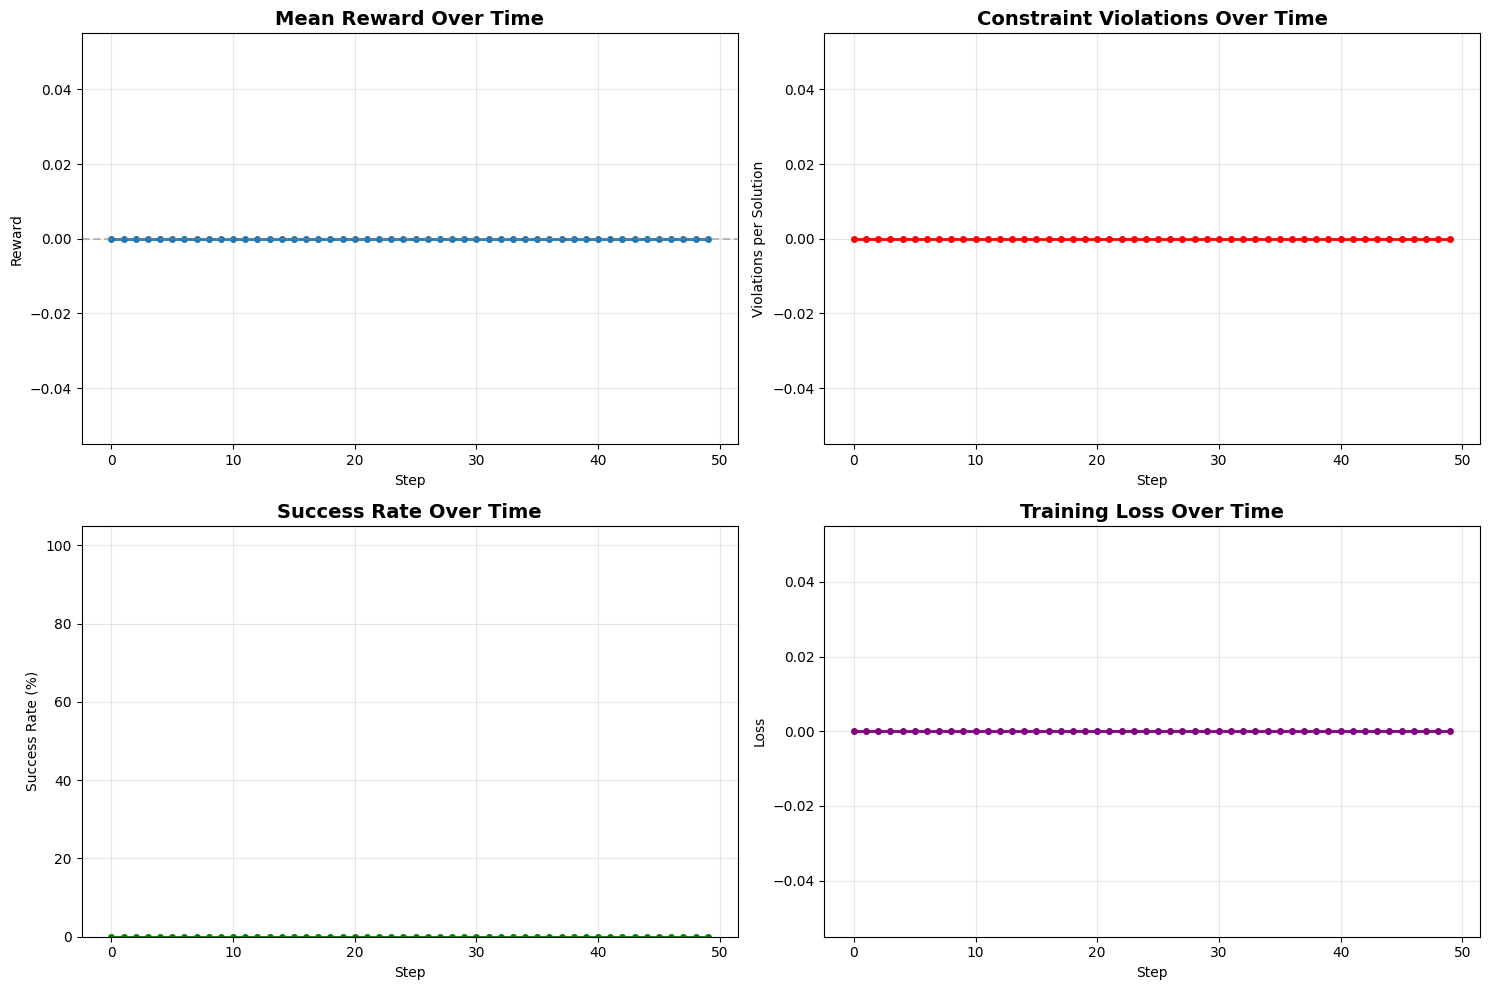

Training curves saved to outputs/colab_pilot/training_curves.png


In [19]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Reward over time
axes[0, 0].plot(steps, rewards, marker='o', linewidth=2, markersize=4)
axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Mean Reward Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True, alpha=0.3)

# Violations over time
axes[0, 1].plot(steps, violations, marker='o', color='red', linewidth=2, markersize=4)
axes[0, 1].set_title('Constraint Violations Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Violations per Solution')
axes[0, 1].grid(True, alpha=0.3)

# Success rate over time
axes[1, 0].plot(steps, [s*100 for s in success_rates], marker='o', color='green', linewidth=2, markersize=4)
axes[1, 0].set_title('Success Rate Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Success Rate (%)')
axes[1, 0].set_ylim([0, 105])
axes[1, 0].grid(True, alpha=0.3)

# Training loss over time
axes[1, 1].plot(steps, losses, marker='o', color='purple', linewidth=2, markersize=4)
axes[1, 1].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/colab_pilot/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to outputs/colab_pilot/training_curves.png")

## Inspect Generated Code Examples

In [20]:
# Show example of what the model generates
import sys
sys.path.insert(0, 'src')

from models.model_wrapper import ModelWrapper

# Load the trained model
print("Loading trained model from checkpoint...")
model = ModelWrapper(
    model_name="outputs/colab_pilot/checkpoints/final_model",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# Test prompt
test_prompt = """# Write a function that returns the sum of two numbers
# DO NOT use: while loop
def solve(a, b):
    """

print("\nGenerating code from trained model...")
print("="*80)
print("PROMPT:")
print(test_prompt)
print("="*80)
print("\nGENERATED SOLUTIONS:\n")

# Generate 3 solutions
solutions = model.generate(
    prompt=test_prompt,
    max_new_tokens=100,
    temperature=0.8,
    num_return_sequences=3
)

for i, sol in enumerate(solutions, 1):
    print(f"Solution {i}:")
    print("-" * 80)
    print(test_prompt + sol)
    print("-" * 80)
    print()

`torch_dtype` is deprecated! Use `dtype` instead!


Loading trained model from checkpoint...
Loading model: outputs/colab_pilot/checkpoints/final_model
  Device: cuda
  Dtype: float32
Model loaded successfully
Parameters: 124.4M

Generating code from trained model...
PROMPT:
# Write a function that returns the sum of two numbers
# DO NOT use: while loop
def solve(a, b):
    

GENERATED SOLUTIONS:

Solution 1:
--------------------------------------------------------------------------------
# Write a function that returns the sum of two numbers
# DO NOT use: while loop
def solve(a, b):
     = a + b
def sum(a, b):
# Add the sum of two numbers together
# AND if a is larger than b then return a
for b in b:
# Take a value from the list of values
# AND return its sum
for b in a:
# Take a value from the list of values
# AND return its sum
return a
def sum(a, b):
# Divide by the sum of two numbers
for b
--------------------------------------------------------------------------------

Solution 2:
--------------------------------------------------

## Download Results



In [21]:
# Zip the results
!zip -r colab_pilot_results.zip outputs/colab_pilot/

# Download in Colab
from google.colab import files
files.download('colab_pilot_results.zip')

print("Results ready for download")

  adding: outputs/colab_pilot/ (stored 0%)
  adding: outputs/colab_pilot/checkpoints/ (stored 0%)
  adding: outputs/colab_pilot/checkpoints/step_24/ (stored 0%)
  adding: outputs/colab_pilot/checkpoints/step_24/merges.txt (deflated 53%)
  adding: outputs/colab_pilot/checkpoints/step_24/special_tokens_map.json (deflated 60%)
  adding: outputs/colab_pilot/checkpoints/step_24/vocab.json (deflated 59%)
  adding: outputs/colab_pilot/checkpoints/step_24/model.safetensors


zip error: Interrupted (aborting)


FileNotFoundError: Cannot find file: colab_pilot_results.zip